In [47]:
import scanpy
import numpy as np
import phate
import matplotlib.pyplot as plt
import scprep
import seaborn as sns
from scipy.spatial.distance import squareform, pdist
from scipy.stats import spearmanr
import pandas as pd

In [2]:
acute = scanpy.read_h5ad('data/acute_tcells.h5ad')
chronic = scanpy.read_h5ad('data/chronic_tcells.h5ad')
adata = scanpy.concat((acute,chronic))
adata.obs['batch'] = adata.obs['batch'].astype('category')

In [3]:
phate_op = phate.PHATE(random_state=42, n_jobs=-1, knn=30)
adata.obsm['X_phate'] = phate_op.fit_transform(adata.to_df())

Calculating PHATE...
  Running PHATE on 39704 observations and 14152 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 15.94 seconds.
    Calculating KNN search...
    Calculated KNN search in 48.91 seconds.
    Calculating affinities...
    Calculated affinities in 6.16 seconds.
  Calculated graph and diffusion operator in 71.54 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 15.55 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.65 seconds.
  Calculated landmark operator in 21.06 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 1.69 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.62 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.62 seconds.
Calculated PHATE in 99.55 seconds.


In [4]:
results = np.load('results/GSPA_QR_without_regression.npz', allow_pickle=True)

In [5]:
np.random.seed(0)
hvgs = np.random.choice(results['genes'], size=int(len(results['genes'])*0.25))

In [7]:
hvg_phate_op = phate.PHATE(random_state=42, n_jobs=-1, knn=30)
data_hvg_phate = hvg_phate_op.fit_transform(adata[:, hvgs].to_df())

Calculating PHATE...
  Running PHATE on 39704 observations and 354 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 10.72 seconds.
    Calculating KNN search...
    Calculated KNN search in 71.58 seconds.
    Calculating affinities...
    Calculated affinities in 18.42 seconds.
  Calculated graph and diffusion operator in 101.09 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 27.25 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.28 seconds.
  Calculated landmark operator in 36.20 seconds.
  Calculating optimal t...
    Automatically selected t = 11
  Calculated optimal t in 1.81 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.52 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.31 seconds.
Calculated PHATE in 143.95 seconds.


In [8]:
threshold = np.percentile(results['localization_score'], q=75)
localized_genes = results['genes'][results['localization_score'] > threshold]

In [9]:
loc_phate_op = phate.PHATE(random_state=42, n_jobs=-1, knn=30)
data_loc_phate = loc_phate_op.fit_transform(adata[:, localized_genes].to_df())

Calculating PHATE...
  Running PHATE on 39704 observations and 354 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.56 seconds.
    Calculating KNN search...
    Calculated KNN search in 59.86 seconds.
    Calculating affinities...
    Calculated affinities in 9.42 seconds.
  Calculated graph and diffusion operator in 70.11 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 18.09 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.11 seconds.
  Calculated landmark operator in 23.36 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 1.65 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.41 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.16 seconds.
Calculated PHATE in 99.70 seconds.


In [10]:
threshold = np.percentile(results['localization_score'], q=25)
nonlocalized_genes = results['genes'][results['localization_score'] < threshold]

In [11]:
nonloc_phate_op = phate.PHATE(random_state=42, n_jobs=-1, knn=30)
data_nonloc_phate = nonloc_phate_op.fit_transform(adata[:, nonlocalized_genes].to_df())

Calculating PHATE...
  Running PHATE on 39704 observations and 354 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.61 seconds.
    Calculating KNN search...
    Calculated KNN search in 53.55 seconds.
    Calculating affinities...
    Calculated affinities in 29.08 seconds.
  Calculated graph and diffusion operator in 83.67 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 34.96 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.01 seconds.
  Calculated landmark operator in 43.77 seconds.
  Calculating optimal t...
    Automatically selected t = 6
  Calculated optimal t in 1.88 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.37 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.66 seconds.
Calculated PHATE in 135.37 seconds.


## Feature selection with localization

In [20]:
methods = ['HVG', 'LOC', 'NONLOC']

In [ ]:
true_geodesic_dist = phate_op.graph.shortest_path(distance='affinity')
true_geodesic_dist = squareform(true_geodesic_dist, checks=False) # is symmetric within tolerance

In [ ]:
for i in range(2):
    idx = np.random.choice(true_geodesic_dist.shape[0], size=100000, replace=False)
    for j,p in enumerate([hvg_phate_op, loc_phate_op]):
        geodesic_dist = p.graph.shortest_path(distance='affinity')
        geodesic_dist = squareform(geodesic_dist, checks=False) # is symmetric within tolerance
        print (methods[j], spearmanr(true_geodesic_dist[idx], geodesic_dist[idx]))

## Visualization

In [ ]:
cmap = dict([(sample,plt.cm.Paired.colors[:6][i]) for i,sample in enumerate(['AcuteD4', 'ChronicD4', 'AcuteD8', 'ChronicD8', 'Acute40', 'Chronic40'])])

<AxesSubplot:title={'center':'Cd3e+ cells'}>

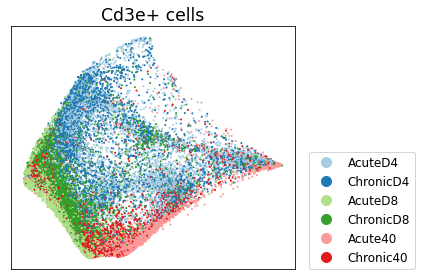

In [10]:
scprep.plot.scatter2d(data_hvg_phate, c=adata.obs['batch'], ticks=None, legend_loc=(1.05,0), 
                      filename='./figures/samples_tcells_hvg.png', dpi=200, title='Cd8+ cells', cmap=cmap, )

<AxesSubplot:title={'center':'Cd3e+ cells'}>

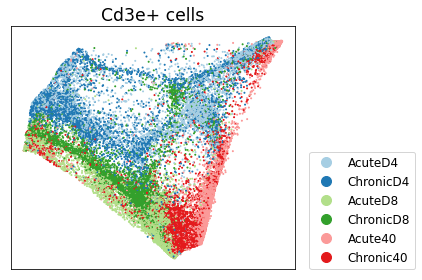

In [21]:
scprep.plot.scatter2d(data_loc_phate*[1,-1], c=adata.obs['batch'], ticks=None, legend_loc=(1.05,0), 
                      filename='./figures/samples_tcells_loc.png', dpi=200, title='Cd8+ cells', cmap=cmap, )

<AxesSubplot:title={'center':'Cd3e+ cells'}>

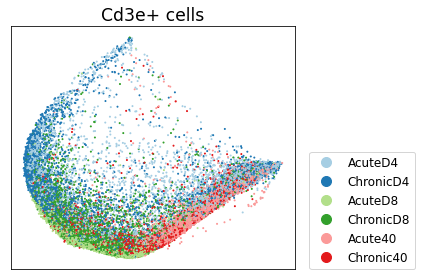

In [16]:
scprep.plot.scatter2d(data_nonloc_phate, c=adata.obs['batch'], ticks=None, legend_loc=(1.05,0), 
                      filename='./figures/samples_tcells_least_loc.png', dpi=200, title='Cd8+ cells', cmap=cmap, )

In [50]:
spearman_results = pd.read_csv('results/reembed_cells_spearmanr.txt', sep=' ', header=None)

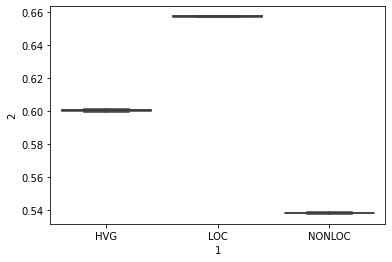

In [55]:
fig, ax = plt.subplots()
sns.boxplot(data=spearman_results[spearman_results[0] == 'Geodesic'], x=1, y=2, ax=ax)
fig.savefig('figures/geodesic_spearmanr.png', dpi=200)